# Statistical Learning and Deep Learning, Fall 2024 HW1
B11705009 An-Che, Liang

## Part1: Ridge Regression Baseline


In [182]:
import pandas as pd
train_df = pd.read_csv('housing_5cities_train.csv')
test_df = pd.read_csv('housing_5cities_testa.csv')

train_df.shape, test_df.shape

((8140, 21), (1031, 21))

### (1-a) Scatter plot for Kaohsiung

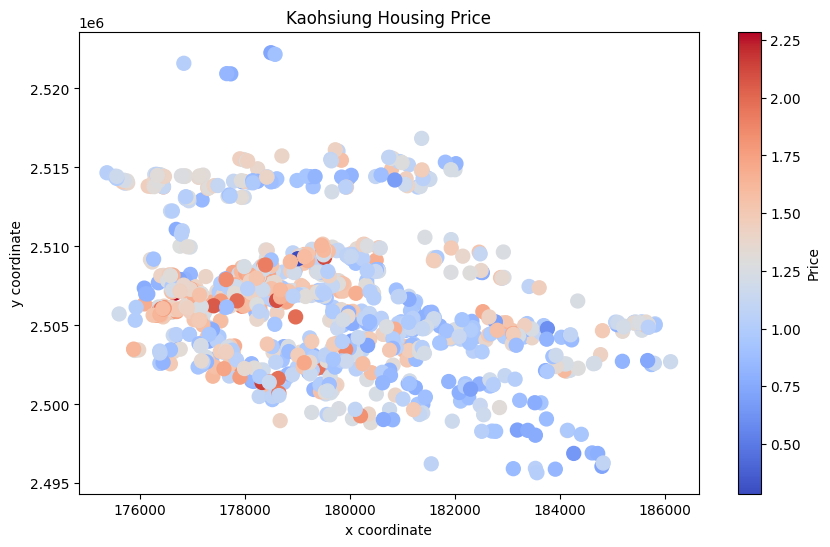

In [183]:
import matplotlib.pyplot as plt


kaohsiung_df = train_df[train_df['縣市'] == '高雄市']
plt.figure(figsize=(10, 6))
sc = plt.scatter(x=kaohsiung_df['橫坐標'], y=kaohsiung_df['縱坐標'],
                 c=kaohsiung_df['單價'], cmap='coolwarm', s=100)
plt.title('Kaohsiung Housing Price')
plt.xlabel("x coordinate")
plt.ylabel('y coordinate')
plt.colorbar(sc, label='Price')
plt.show()

**Observations:**
1. The arrangement of houses suggests the rough outline of roads, as they are aligned in vertical and horizontal patterns.
2. Houses located closer to the city center tend to be more expensive, as indicated by the red color.

### (1-b) Ridge Regression model for price prediction

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


features = ['建物面積', '總樓層數', '屋齡', '縣市', '鄉鎮市區', '主要用途', '主要建材', '建物型態']
target = '單價'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

numeric_features = ['建物面積', '總樓層數', '屋齡']
categorical_features = ['縣市', '鄉鎮市區', '主要用途', '主要建材', '建物型態']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())])

In [185]:
import numpy as np
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-2, 2, 10) 
param_grid = {'ridge__alpha': alphas}
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['建物面積',
                                                                          '總樓層數',
                                                                          '屋齡']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['縣市',
                                                                          '鄉鎮市區',
                                                                          '主要用途',
                                                                          '主要建材',
                                                                          '建物型態'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [186]:
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Regularization Coefficient (alpha) for the best model: {best_alpha}")


Regularization Coefficient (alpha) for the best model: 0.5994842503189409


In [187]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

R2: 0.7681039117131876
RMSE: 0.50433523322633
MAE: 0.2817464207485563
MAPE: 13.290491595265518%


In [188]:
intercept = best_model.named_steps['ridge'].intercept_
coefficients = best_model.named_steps['ridge'].coef_
feature_names = numeric_features + \
    list(best_model.named_steps['preprocessor'].transformers_[
         1][1].get_feature_names_out())

highlights = ['建物面積', '總樓層數', '屋齡', '縣市_台中市',
              '縣市_台北市', '縣市_新北市', '縣市_桃園市', '縣市_高雄市']

print(f"Constant term coefficient: {intercept}")
for name, coef in zip(feature_names, coefficients):
    if name in highlights:
        print(f"{name}: {coef}")

Constant term coefficient: 1.7575750904026146
建物面積: 0.0026140774863405033
總樓層數: 0.033052109092531895
屋齡: -0.31161038873042396
縣市_台中市: -0.45239789230933797
縣市_台北市: 1.6393385781151582
縣市_新北市: 0.03991651019215602
縣市_桃園市: -0.624030703701911
縣市_高雄市: -0.6028264923023551


## Part2: Gaussian Basis Function

### (2-a) Anchor point and standard deviation

In [189]:
anchor_x = kaohsiung_df['橫坐標'].mean()
anchor_y = kaohsiung_df['縱坐標'].mean()
std_x = kaohsiung_df['橫坐標'].std()
std_y = kaohsiung_df['縱坐標'].std()

print(f"Anchor point: ({anchor_x}, {anchor_y})")
print(f"Standard deviation: x:{std_x}, y:{std_y}")

Anchor point: (179372.98594189316, 2506459.4170571696)
Standard deviation: x:2314.822815823647, y:4033.384556043726


### (2-b) GBF feature values

In [190]:
def gaussian_basis_function(x_a, y_a, mu_xj, mu_yj, s_xj, s_yj):
    return np.exp(- ((x_a - mu_xj)**2 / (2 * s_xj**2)) - ((y_a - mu_yj)**2 / (2 * s_yj**2)))


train_df['GBF_feature'] = gaussian_basis_function(
    train_df['橫坐標'], train_df['縱坐標'], anchor_x, anchor_y, std_x, std_y)

gbf_stats = train_df.groupby('縣市')['GBF_feature'].describe()
print(gbf_stats)

      count      mean       std       min       25%       50%       75%  \
縣市                                                                        
台中市   810.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
台北市  1906.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
新北市  3432.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
桃園市   925.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
高雄市  1067.0  0.519141  0.292717  0.000432  0.258577  0.559224  0.763008   

          max  
縣市             
台中市  0.000000  
台北市  0.000000  
新北市  0.000000  
桃園市  0.000000  
高雄市  0.994381  


## Part3: Applying GBF in Prediction Models

### (3-a) Generate anchor points

In [191]:
def generate_anchors(df, K):
    anchors = {}

    for city in df['縣市'].unique():
        city_df = df[df['縣市'] == city]

        x_min, x_max = city_df['橫坐標'].min(), city_df['橫坐標'].max()
        y_min, y_max = city_df['縱坐標'].min(), city_df['縱坐標'].max()

        x_grid = np.linspace(x_min, x_max, K+1)
        y_grid = np.linspace(y_min, y_max, K+1)

        city_anchors = []

        for i in range(K):
            for j in range(K):
                grid_df = city_df[(city_df['橫坐標'] >= x_grid[i]) & (city_df['橫坐標'] < x_grid[i+1]) &
                                  (city_df['縱坐標'] >= y_grid[j]) & (city_df['縱坐標'] < y_grid[j+1])]

                if len(grid_df) > 20:
                    anchor_x = float(grid_df['橫坐標'].mean())
                    anchor_y = float(grid_df['縱坐標'].mean())
                    std_x = float(grid_df['橫坐標'].std())
                    std_y = float(grid_df['縱坐標'].std())
                    city_anchors.append((anchor_x, anchor_y, std_x, std_y))

        anchors[city] = city_anchors

    return anchors


K = 3

anchors = generate_anchors(train_df, K)
for city, city_anchors in anchors.items():
    print(f"{city}: {len(city_anchors)} anchors")
    for i, anchor in enumerate(city_anchors):
        print(f"Anchor {i+1}: ({anchor[0]:.2f}, {anchor[1]:.2f}) ")

台北市: 8 anchors
Anchor 1: (300711.67, 2768906.27) 
Anchor 2: (301296.24, 2772116.72) 
Anchor 3: (300595.49, 2779851.05) 
Anchor 4: (304968.34, 2768095.45) 
Anchor 5: (304675.45, 2772124.59) 
Anchor 6: (303477.96, 2778399.44) 
Anchor 7: (307985.69, 2766744.43) 
Anchor 8: (309774.70, 2773019.32) 
高雄市: 8 anchors
Anchor 1: (177731.81, 2502636.41) 
Anchor 2: (177477.70, 2507344.14) 
Anchor 3: (177080.35, 2514791.70) 
Anchor 4: (180475.25, 2502265.41) 
Anchor 5: (180306.96, 2507356.14) 
Anchor 6: (180625.00, 2514727.41) 
Anchor 7: (183739.58, 2501413.13) 
Anchor 8: (184236.88, 2505555.37) 
新北市: 6 anchors
Anchor 1: (292369.03, 2763437.33) 
Anchor 2: (293614.66, 2772099.61) 
Anchor 3: (295035.54, 2784392.38) 
Anchor 4: (301675.79, 2764930.08) 
Anchor 5: (299145.38, 2772523.14) 
Anchor 6: (315203.67, 2773318.52) 
桃園市: 5 anchors
Anchor 1: (266614.75, 2758049.46) 
Anchor 2: (274733.30, 2760077.69) 
Anchor 3: (275567.70, 2767639.65) 
Anchor 4: (281004.42, 2762377.46) 
Anchor 5: (281939.73, 2768091.

### (3-b) GBF as new feature in regression model

In [192]:
def calculate_gbf_features(df, anchors):
    for city, city_anchors in anchors.items():
        city_mask = df['縣市'] == city

        for i, (anchor_x, anchor_y, std_x, std_y) in enumerate(city_anchors):
            gbf_feature = gaussian_basis_function(df.loc[city_mask, '橫坐標'],
                                                  df.loc[city_mask, '縱坐標'],
                                                  anchor_x, anchor_y, std_x, std_y)
            df.loc[city_mask, f'GBF_{city}_{i}'] = gbf_feature
    return df

In [193]:
train_df = calculate_gbf_features(train_df, anchors)
test_df = calculate_gbf_features(test_df, anchors)
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [194]:
print(train_df.columns)
numeric_features = ['建物面積', '總樓層數', '屋齡'] + \
    [col for col in train_df.columns if 'GBF' in col and col != 'GBF_feature']
categorical_features = ['縣市', '鄉鎮市區', '主要用途', '主要建材', '建物型態']

Index(['縣市', '鄉鎮市區', '路名', '土地面積', '使用分區', '移轉層次', '總樓層數', '主要用途', '主要建材',
       '建物型態', '屋齡', '建物面積', '車位面積', '車位個數', '橫坐標', '縱坐標', '備註', '主建物面積',
       '陽台面積', '附屬建物面積', '單價', 'GBF_feature', 'GBF_台北市_0', 'GBF_台北市_1',
       'GBF_台北市_2', 'GBF_台北市_3', 'GBF_台北市_4', 'GBF_台北市_5', 'GBF_台北市_6',
       'GBF_台北市_7', 'GBF_高雄市_0', 'GBF_高雄市_1', 'GBF_高雄市_2', 'GBF_高雄市_3',
       'GBF_高雄市_4', 'GBF_高雄市_5', 'GBF_高雄市_6', 'GBF_高雄市_7', 'GBF_新北市_0',
       'GBF_新北市_1', 'GBF_新北市_2', 'GBF_新北市_3', 'GBF_新北市_4', 'GBF_新北市_5',
       'GBF_桃園市_0', 'GBF_桃園市_1', 'GBF_桃園市_2', 'GBF_桃園市_3', 'GBF_桃園市_4',
       'GBF_台中市_0', 'GBF_台中市_1', 'GBF_台中市_2', 'GBF_台中市_3', 'GBF_台中市_4'],
      dtype='object')


In [197]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())])

alphas = np.logspace(-2, 2, 10)

X_train = train_df[numeric_features + categorical_features]
y_train = train_df[target]
X_test = test_df[numeric_features + categorical_features]
y_test = test_df[target]

In [198]:
param_grid = {'ridge__alpha': alphas}
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['建物面積',
                                                                          '總樓層數',
                                                                          '屋齡',
                                                                          'GBF_台北市_0',
                                                                          'GBF_台北市_1',
                                                                          'GBF_台北市_2',
                                                                          'GBF_台北市_3',
                                                                          'GBF_台北市_4',
                                                                          'GBF_台北市_5',
                                                                          'GBF_台北市_6',
                                                                          'GBF_台北市_7',
                                                                          'GBF_高雄市_0',
                                                                          'GBF_高雄市_1',
                                                                          'GBF_高雄市_2',
                                                                          'GBF_高雄市_3',
                                                                          'GBF_高雄市_4',
                                                                          'GBF_高雄市_5',
                                                                          'GBF_高雄市_6',
                                                                          'GBF_高雄市_7',
                                                                          'GBF_新北市_0',
                                                                          'GBF_新北市_1...
                                                                          'GBF_桃園市_3',
                                                                          'GBF_桃園市_4', ...]),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['縣市',
                                                                          '鄉鎮市區',
                                                                          '主要用途',
                                                                          '主要建材',
                                                                          '建物型態'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [199]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_df[numeric_features + categorical_features])

r2 = r2_score(test_df['單價'], y_pred)
rmse = np.sqrt(mean_squared_error(test_df['單價'], y_pred))
mae = mean_absolute_error(test_df['單價'], y_pred)
mape = np.mean(np.abs((test_df['單價'] - y_pred) / test_df['單價'])) * 100

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

R2: 0.7806908670197453
RMSE: 0.4904570220873389
MAE: 0.27151365102266733
MAPE: 12.845419618494667%
